# S11 dB

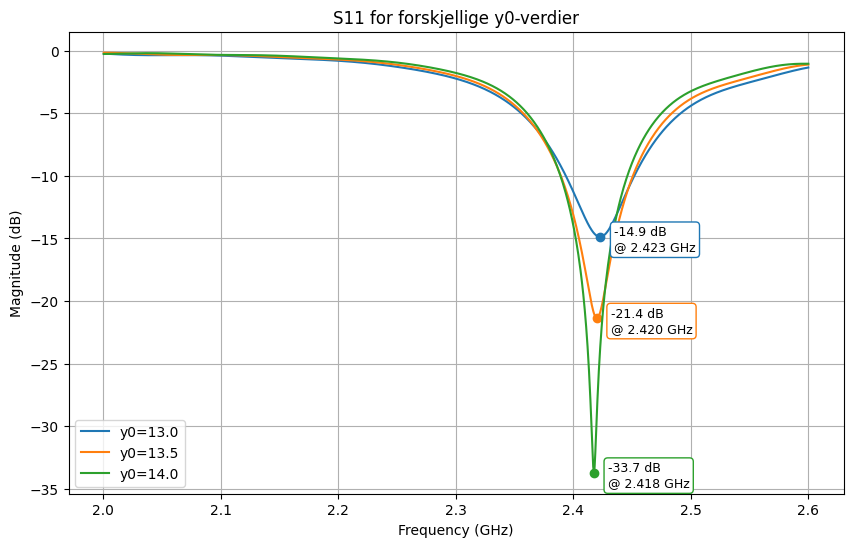

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths
file_path = 'CST_Data/S11_Sweep.txt'

# Define the line ranges for each y0 value
ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Initialize empty DataFrame to store all data
df = pd.DataFrame()

# Read the first file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', names=["Frequency / GHz", f"{y0}"])
    if df.empty:
        df = data
    else:
        df = pd.merge(df, data, on="Frequency / GHz")

# Plot the data from the first file
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }
fig, ax = plt.subplots(figsize=(10, 6))

for column in df.columns[1:]:
    ax.plot(df["Frequency / GHz"], df[column], label=column, color=colors[column])
    
    # Find the minimum value
    min_value = df[column].min()
    min_index = df[column].idxmin()
    min_frequency = df["Frequency / GHz"][min_index]

    # Plot the minimum point
    ax.plot(min_frequency, min_value, 'o', color=colors[column])
    
    # Annotate with frequency and min value
    ax.annotate(
        f"{min_value:.1f} dB\n@ {min_frequency:.3f} GHz",
        (min_frequency, min_value),
        textcoords="offset points",
        xytext=(10, -10),
        ha='left',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[column], facecolor="white")
    )

# Plot formatting
ax.set_title('S11 for forskjellige y0-verdier')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Magnitude (dB)')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

# S11 Smith Chart

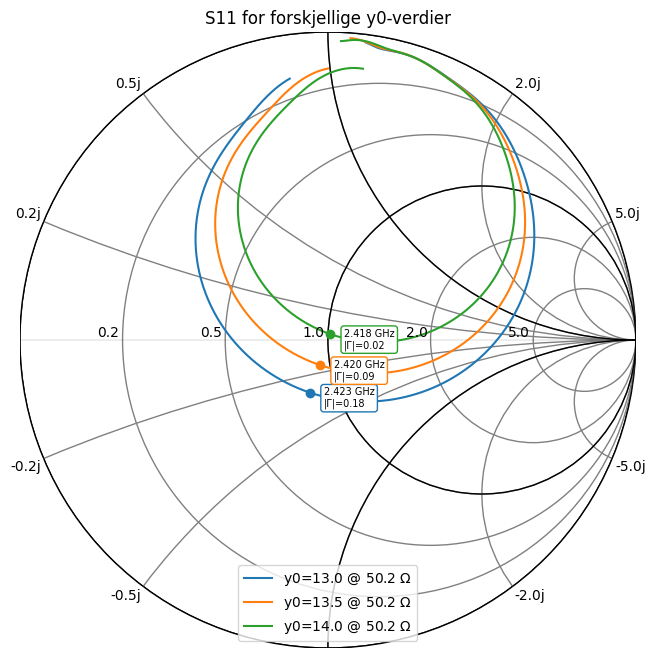

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np

file_path = 'CST_Data/S11_Sweep_Smith.txt'

ranges = {
    'y0=13.0': (4, 1004),
    'y0=13.5': (1008, 2008),
    'y0=14.0': (2012, 3012)
}

# Dictionary to store Network objects
networks = {}
ref_mags = {}

# Read the file and extract data for each y0 value
for y0, (start, end) in ranges.items():
    data = pd.read_csv(file_path, skiprows=start, nrows=end-start, delimiter='\t', 
                       names=["Frequency", "Mag", "Phase", "Ref Mag", "Ref Phase"])
    
    frequency = data["Frequency"].values * 1e9  # Convert GHz to Hz
    s11_mag = data["Mag"].values
    s11_phase = data["Phase"].values
    
    # Compute complex reflection coefficient (Gamma)
    s11_complex = s11_mag * np.exp(1j * np.deg2rad(s11_phase))
    
    # Store network
    networks[y0] = rf.Network(frequency=frequency, s=s11_complex)
    ref_mags[y0] = data["Ref Mag"].values[0]

# Define colors
colors = { 'y0=13.0': 'tab:blue', 'y0=13.5': 'tab:orange', 'y0=14.0': 'tab:green' }

# Create figure and plot Smith chart
fig, ax = plt.subplots(figsize=(8, 8))

rf.plotting.smith(ax=ax, draw_labels=True, ref_imm=1, chart_type='z')

for y0, network in networks.items():
    # Plot S11
    network.plot_s_smith(ax=ax, label=rf"{y0} @ {ref_mags[y0]:.1f} $\Omega$", color=colors[y0])
    
    # Find the point closest to the center (|Γ| closest to 0)
    distances = np.abs(network.s[:, 0, 0])
    min_index = np.argmin(distances)
    closest_point = network.s[min_index, 0, 0]
    closest_frequency = frequency[min_index] / 1e9  # Convert Hz to GHz
    
    # Plot the marker
    ax.plot(closest_point.real, closest_point.imag, 'o', color=colors[y0])
    
    # Annotate with frequency and |Γ|
    ax.annotate(
        f"{closest_frequency:.3f} GHz\n|Γ|={np.abs(closest_point):.2f}", 
        (closest_point.real, closest_point.imag),
        textcoords="offset points", xytext=(10,-10), ha='left', fontsize=7, 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[y0], facecolor="white")
    )

# Add title and legend
ax.set_title('S11 for forskjellige y0-verdier')
ax.legend(loc='lower center')

# Set axis limits and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Add grid and ticks
ax.grid(True, which='both')
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, 
               colors='black', grid_color='gray', grid_alpha=0.5)

# Show the plot
plt.show()


# Farfield Plots

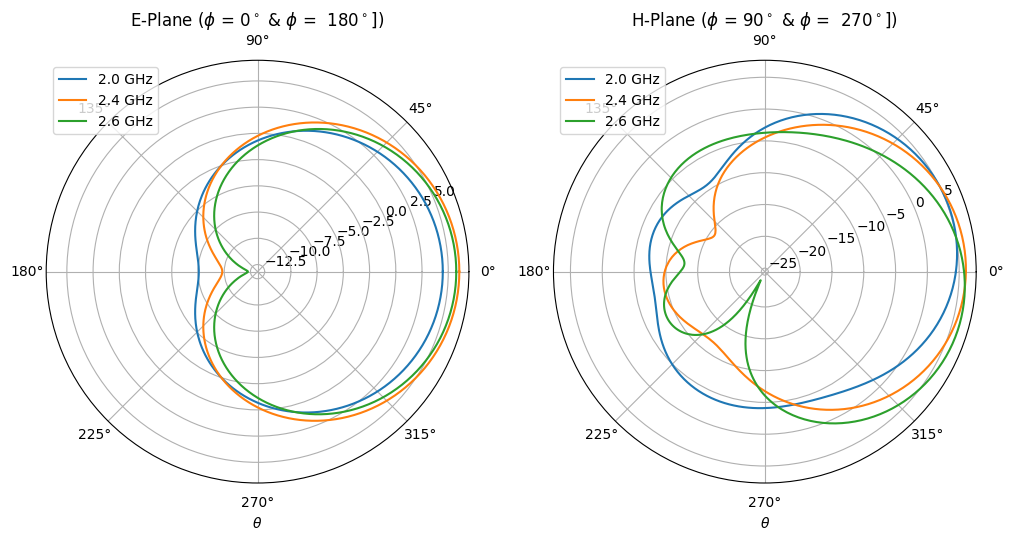

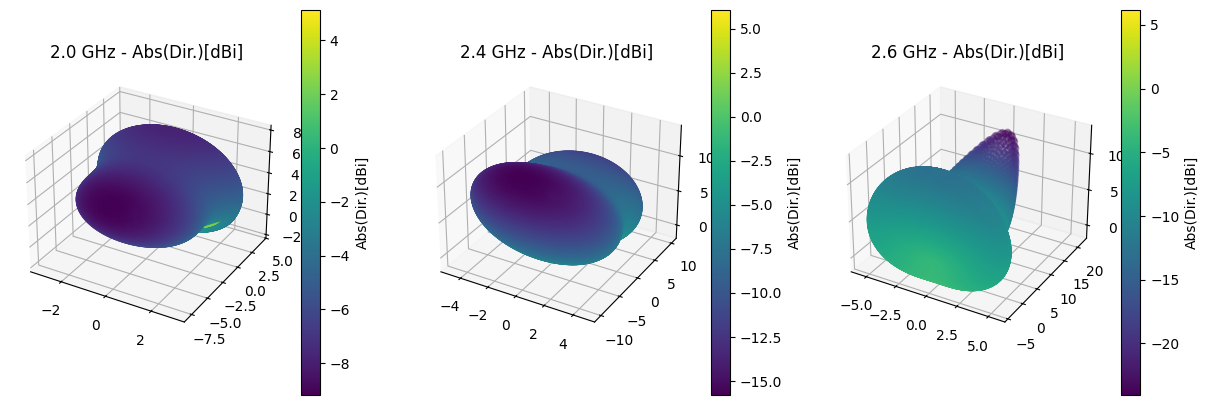

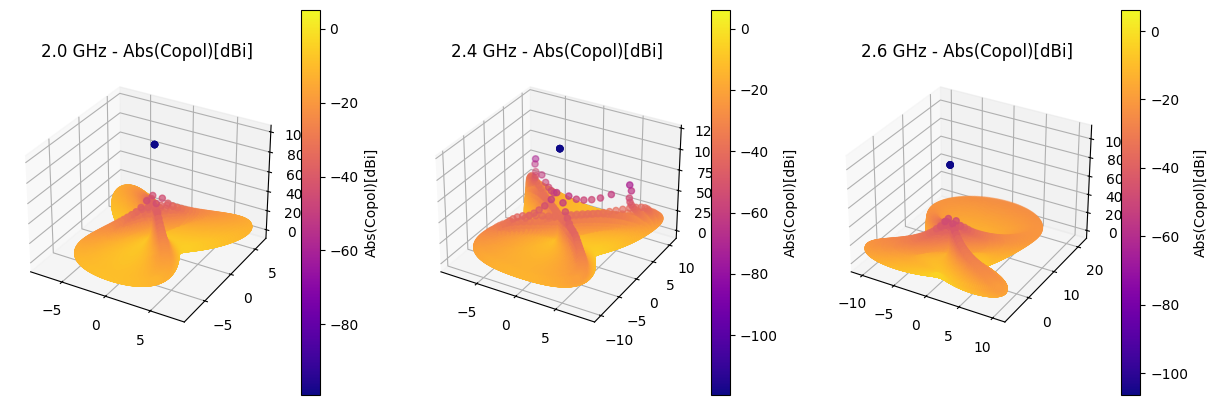

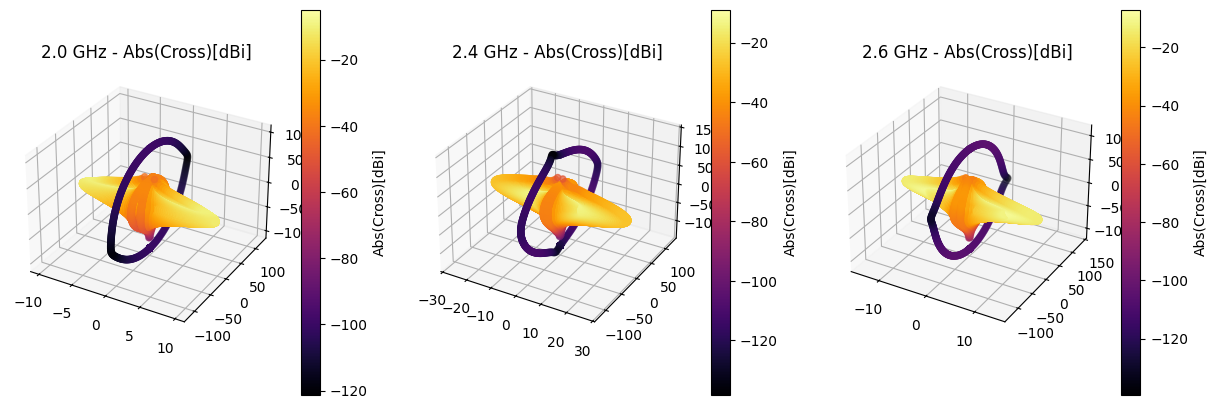

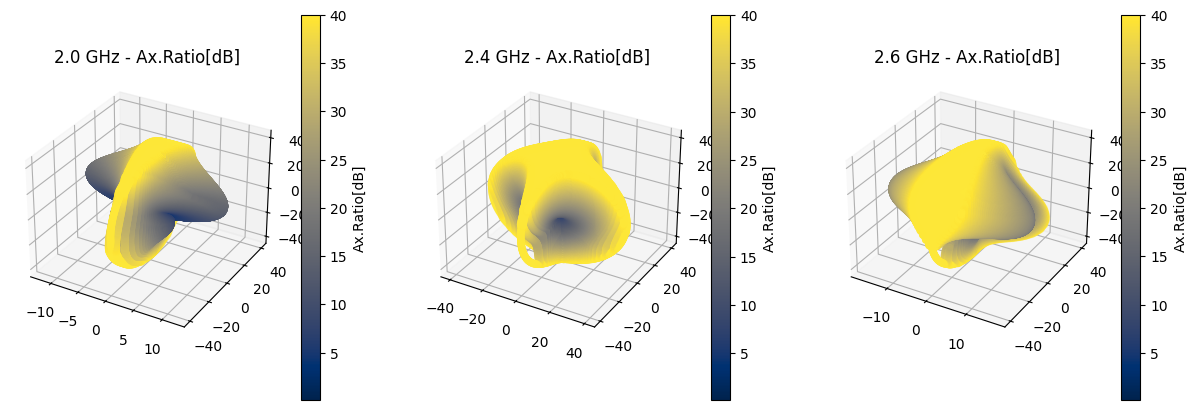

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Les inn dataen
file_paths = {
    '2.0 GHz': 'CST_Data/2_0GHz3D.txt',
    '2.4 GHz': 'CST_Data/2_4GHz3D.txt',
    '2.6 GHz': 'CST_Data/2_6GHz3D.txt'
}

columns = ["Theta [deg.]", "Phi [deg.]", "Abs(Dir.)[dBi]", "Abs(Cross)[dBi]", "Phase(Cross)[deg.]", 
           "Abs(Copol)[dBi]", "Phase(Copol)[deg.]", "Ax.Ratio[dB]"]

datasets = {freq: pd.read_csv(path, skiprows=2, names=columns, sep=r"\s+") for freq, path in file_paths.items()}

def plot_polar(datasets):
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))
    
    for freq, data in datasets.items():
        # Del opp i E- og H-plan
        e_plane1 = data[data["Phi [deg.]"].isin([0])]
        e_plane2 = data[data["Phi [deg.]"].isin([180])].copy()
        e_plane2["Theta [deg.]"] = 360 - e_plane2["Theta [deg.]"]
        e_plane = pd.concat([e_plane1, e_plane2])
        
        h_plane1 = data[data["Phi [deg.]"].isin([90])]
        h_plane2 = data[data["Phi [deg.]"].isin([270])].copy()
        h_plane2["Theta [deg.]"] = 360 - h_plane2["Theta [deg.]"]
        h_plane = pd.concat([h_plane1, h_plane2])
        
        # Sorter for å unngå streker mellom ikke-sammenhengende punkter
        e_plane = e_plane.sort_values(by="Theta [deg.]")
        h_plane = h_plane.sort_values(by="Theta [deg.]")
        
        # E-plan
        ax[0].plot(np.radians(e_plane["Theta [deg.]"].values), e_plane["Abs(Copol)[dBi]"].values, label=f"{freq}")
        ax[0].set_title(r"E-Plane ($\phi$ = $0^\circ$ & $\phi$ =  $180^\circ$])")
        ax[0].set_xlabel(r"$\theta$")
        
        # H-plan
        ax[1].plot(np.radians(h_plane["Theta [deg.]"].values), h_plane["Abs(Copol)[dBi]"].values, label=f"{freq}")
        ax[1].set_title(r"H-Plane ($\phi$ = $90^\circ$ & $\phi$ =  $270^\circ$])")
        ax[1].set_xlabel(r"$\theta$")
    
    ax[0].legend()
    ax[1].legend()
    plt.show()

def plot_3d(datasets, param, cmap='viridis'):
    fig = plt.figure(figsize=(15, 5))
    
    for i, (freq, data) in enumerate(datasets.items(), 1):
        ax = fig.add_subplot(1, len(datasets), i, projection='3d')
        
        theta = np.radians(data["Theta [deg.]"])
        phi = np.radians(data["Phi [deg.]"])
        r = data[param]
        
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        
        sc = ax.scatter(x, y, z, c=r, cmap=cmap, marker='o')
        fig.colorbar(sc, ax=ax, label=param)
        ax.set_title(f"{freq} - {param}")
    
    plt.show()

# Plot for alle frekvenser
plot_polar(datasets)
plot_3d(datasets, "Abs(Dir.)[dBi]", cmap='viridis')  # Direktivitet
plot_3d(datasets, "Abs(Copol)[dBi]", cmap='plasma')  # Copolarized
plot_3d(datasets, "Abs(Cross)[dBi]", cmap='inferno') # Cross-polarized
plot_3d(datasets, "Ax.Ratio[dB]", cmap='cividis')   # Axial ratio
